In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import time

import tensorflow as tf
import datetime
from torchsummary import summary


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
# Hyperparameters
nbEpochs = 50
train_batch_size = 128
test_batch_size = 128
#Check the end of the document for controls of dense dim and lambda superseding these changes
dropoutChance = 0.5
denseLayerNeurons = 1024
lossControlPenalty = 0.7 # controlPenalty = 0.4...0.7
source = "SVHN"
target = "MNIST"
optimizerName = "Adam" #Adam or RMSProp
sourceChannels = 1
learningRate = 1e-4
weight_decay = 5e-6 #Only relevant for RMSProp

dataPath = os.path.dirname(os.getcwd()) + "/data/"
# log_dir = os.path.dirname(os.getcwd()) + "/logs/"
randomSeed = 1905

In [0]:
# Fix the random seeds
def setSeeds(randomSeed):
  """ Based on: https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752"""
  np.random.seed(randomSeed)
  torch.manual_seed(randomSeed)
  os.environ['PYTHONASHSEED']=str(randomSeed)
  #random.seed(randomSeed)
setSeeds(randomSeed)

In [0]:
class GaussianDenoising:
    """Applies to Tensor. Distort a pixel with 
	additive [+ N(0,scale)] or multiplicative 
	[x N(1,scale)] gaussian noise"""

    def __init__(self, mean = 0, sigma = 0.2, effectType = "additive"):
        means = {"additive": 0, "multiplicative": 1}        
        self.sigma = sigma
        self.effectType = effectType
        if(mean == 0):
            self.mean = means[effectType]

    def __call__(self, x):
        if self.effectType == "multiplicative":
            return x.numpy() * np.random.normal(loc = 1.0, scale = sigma, size = x.shape)
        elif self.effectType == "additive":
            return x.numpy + np.random.normal(loc = 0.0, scale = sigma, size = x.shape)
        else:
            print("Specify a valid type of gaussian error: multiplicative or additive")
            raise ValueError

In [0]:
# Impulse denoising as described in paper
class ImpulseDenoising:
    """Erase a pixel with probability p"""

    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, x):
        return x.numpy() * np.random.binomial(1, self.p, size=x.shape)

In [0]:
# Data Transforms

# image data augments are performed on all images before they're transformed to tensors
# tensor data augments are performed on source and target after they're transformed to tensors
# MNIST / SVHN transforms are performed only on MNIST / SVHN data, and include a toTensor transformation

# Data Augmentation - Geometric Transformations
# 20º random rotation
# 20% random height and width shifts
imageDataAugmentTransforms = []
imageDataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20))
#imageDataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2)))
# Denoising
tensorDataAugmentTransforms = []
tensorDataAugmentTransforms.append(ImpulseDenoising())
# tensorDataAugmentTransforms.append(GaussianDenoising(0.2, additive))


MNIST_Transforms = []
MNIST_Transforms.append(torchvision.transforms.Resize((32,32), interpolation = 2)) #Rescale to SVHN size
MNIST_Transforms.append(torchvision.transforms.ToTensor())
MNIST_Transforms.append(torchvision.transforms.Normalize(0.5,0.5))

SVHN_Transforms = []
SVHN_Transforms.append(torchvision.transforms.Grayscale())
SVHN_Transforms.append(torchvision.transforms.ToTensor())
SVHN_Transforms.append(torchvision.transforms.Normalize(0.5,0.5))

In [25]:
# Create the data loaders

train_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = True, download = True, \
                transform = torchvision.transforms.Compose\
                (imageDataAugmentTransforms + MNIST_Transforms + tensorDataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = False, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms)), batch_size = test_batch_size, shuffle = True)

#DataLoader has irregular behaviour, does not autom create an SVHN folder but does so for MNIST
train_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "train", download = True, \
                transform = torchvision.transforms.Compose\
                (imageDataAugmentTransforms + SVHN_Transforms + tensorDataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "test", download = True , \
                 transform = torchvision.transforms.Compose \
                (SVHN_Transforms)), batch_size = test_batch_size, shuffle = True)


Extracting //data/MNIST/raw/train-images-idx3-ubyte.gz to //data/MNIST/raw


Extracting //data/MNIST/raw/train-labels-idx1-ubyte.gz to //data/MNIST/raw


Extracting //data/MNIST/raw/t10k-images-idx3-ubyte.gz to //data/MNIST/raw


Extracting //data/MNIST/raw/t10k-labels-idx1-ubyte.gz to //data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = [16,9]    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Source Domain batch


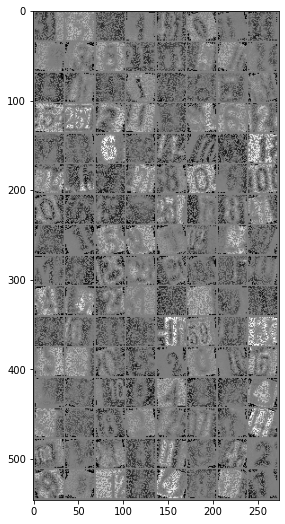

Target Domain batch


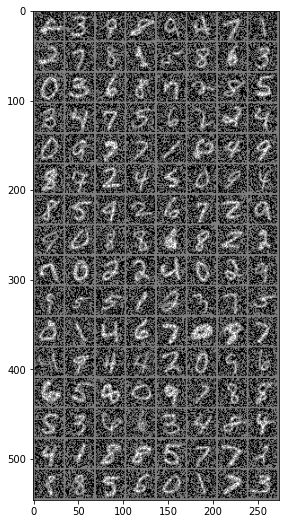

In [27]:
# get some random training images from source
batch_id, (images, labels) = next(enumerate(train_SVHN_loader))

print('Source Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
batch_id, (images, labels) = next(enumerate(train_MNIST_loader))

print('Target Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# Some padding calculation tools. Currently unused

def calcConvSamePadding(input, convNet, nDim = 2):
  """ Calculates padding required for convNet to produce output of same dimensions as input """
  pad_h = math.ceil((convNet.kernel_size[0] - input.shape[2] * (1 - convNet.stride[0]) - convNet.stride[0]) / 2)
  pad_w = math.ceil((convNet.kernel_size[1] - input.shape[3] * (1 - convNet.stride[1]) - convNet.stride[1]) / 2)
  return (pad_h, pad_h, pad_w, pad_w)

def calcPoolSamePadding(input, poolNet, nDim = 2): 
  """ Calculates padding required for poolNet to produce output of same dimensions as input """
  pad_h = math.ceil(((input.shape[2] - 1)*poolNet.stride[0] + 1 + poolNet.dilation*(poolNet.kernel_size[0] - 1) - input.shape[2])/2)
  pad_w = math.ceil(((input.shape[3] - 1)*poolNet.stride[1] + 1 + poolNet.dilation*(poolNet.kernel_size[1] - 1) - input.shape[3])/2)
  return (pad_h, pad_h, pad_w, pad_w)

In [0]:
# Some dimension calculation tools. Currently unused
def calcConvOutputDimensions(inputDim, kernelSize, padding = (0,0), dilation = (1,1), stride = (1,1)):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, kernelSize, padding, dilation, stride]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    Hout = math.floor((variables[0][0] + 2*variables[2][0] - variables[3][0]*(variables[1][0] - 1) -1)/variables[4][0] + 1)
    Wout = math.floor((variables[0][1] + 2*variables[2][1] - variables[3][1]*(variables[1][1] - 1) -1)/variables[4][1] + 1)
    return (Hout, Wout)

def calcPoolOutputDimensions(inputDim, pooling):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, pooling]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    if len(inputDim) != len(pooling):
        raise ValueError
    return tuple(int(inputDim[i]/pooling[i]) for i,ti in enumerate(pooling) )


In [0]:
# Models
class Encoder(nn.Module):
    """Encoder common to Autoencoder and labeller"""

    def __init__(self, inputChannels, dropoutChance = 0.5, denseLayerNeurons = 300):
        """Initialize DomainRegressor."""
        super(Encoder, self).__init__()
        
        #Size Parameters
        
        conv1Filters = 100
        conv1KernelSize = 5
        maxPool1Size = (2,2)
        
        conv2Filters = 150
        conv2KernelSize = 5
        maxPool2Size = (2,2)
        
        conv3Filters = 200
        conv3KernelSize = 3
        
        # Placeholder ranges
        fc4OutputDim = denseLayerNeurons
        fc5OutputDim = denseLayerNeurons
        
        
        # Convolutional Layers Size Calculations
        conv1InputChannels = inputChannels
        conv2InputChannels = conv1Filters
        conv3InputChannels = conv2Filters
                
        # Convolutional Layers
        self.conv1 = nn.Conv2d(conv1InputChannels, conv1Filters, conv1KernelSize, padding = 2)      
        self.maxPool2D1 = nn.MaxPool2d(maxPool1Size)       
        self.conv2 = nn.Conv2d(conv2InputChannels, conv2Filters, conv2KernelSize, padding = 2)        
        self.maxPool2D2 = nn.MaxPool2d(maxPool2Size)
        self.conv3 = nn.Conv2d(conv3InputChannels, conv3Filters, conv3KernelSize, padding = 1)

        fc4InputDim = conv3Filters*8*8 # 8 is the final h x w dimension of the tensors when passed to the dense layer
        fc5InputDim = fc4OutputDim
        
        # Fully connected Layers
        self.fc4 = nn.Linear(fc4InputDim, fc4OutputDim)
        self.dropout4 = nn.Dropout2d(p = dropoutChance)
        
        self.fc5 = nn.Linear(fc5InputDim, fc5OutputDim)
        self.dropout5 = nn.Dropout2d(p = dropoutChance)
        
        

    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        x = F.relu(self.conv1(x.float()))
        x = self.maxPool2D1(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxPool2D2(x)

        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        x = self.dropout5(x)
        return x

In [0]:
class Labeller(nn.Module):
    """ The labeller part of the network is constituted by 
    the common Encoder plus a labelling fully connected layer"""
    
    def __init__(self, encoder, n_classes = 10):
      """ n_classes is the number of output labels"""
      super(Labeller, self).__init__()
      self.encoder = encoder
      # As many in features as the previous layer's out features
      self.fcOUT = nn.Linear(self.encoder.fc5.out_features, n_classes)  
        
    def forward(self, x):
        x = self.encoder(x)
        return self.fcOUT(x)

    

In [0]:
class Autoencoder(nn.Module):
    """The autoencoder is constituted by the Encoder common to
    the labeller and itself, and a decoder part that is a mirror
    image of the Encoder
    
    Layers 6 and 7 are FC layers, layers 8 through 10 are (de)convolutional layers
    
    """

    def __init__(self, encoder):
        """Initialize DomainRegressor."""
        super(Autoencoder, self).__init__()
        
        self.encoder = encoder

        # Layers
        self.fc6 = nn.Linear(self.encoder.fc5.out_features, self.encoder.fc5.in_features)
        self.fc7 = nn.Linear(self.encoder.fc4.out_features,  self.encoder.fc4.in_features)
        

        #Layer 8 is an extra layer in the author's github implementation wrt the paper.
        self.deconv8 = nn.Conv2d(self.encoder.conv3.out_channels, self.encoder.conv3.out_channels, self.encoder.conv3.kernel_size, padding = 1)
        self.deconv9 = nn.Conv2d(self.encoder.conv3.out_channels, self.encoder.conv3.in_channels, self.encoder.conv3.kernel_size, padding = 1)
        self.upsample9 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv10 = nn.Conv2d(self.encoder.conv2.out_channels, self.encoder.conv2.in_channels, self.encoder.conv2.kernel_size, padding = 2)
        self.upsample10 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv11 = nn.Conv2d(self.encoder.conv1.out_channels, self.encoder.conv1.in_channels, self.encoder.conv1.kernel_size, padding = 2)

    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        x = self.encoder(x)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        x = torch.reshape(x, (x.shape[0], self.deconv8.in_channels, 8, 8))
        # x = F.relu(self.deconv8(x))
        x = F.relu(self.deconv9(x))
        x = self.upsample9(x)
        x = F.relu(self.deconv10(x))
        x = self.upsample10(x)
        x = self.deconv11(x)

        return x

In [0]:
def weights_init(m):
      if isinstance(m, nn.Conv2d):
          nn.init.xavier_uniform_(m.weight.data, gain=1)
          nn.init.constant_(m.bias.data, 0.1)




In [0]:
def getSettings():
  settings = {}
  settings["optimizer"] = optimizerName
  settings["learningRate"] = learningRate
  if(optimizerName == "RMSProp"):
    settings["weight_decay"] = weight_decay
  settings["Epochs"] = nbEpochs
  settings["train_batch_size"] = train_batch_size
  settings["test_batch_size"] = test_batch_size
  settings["dropoutChance"] = dropoutChance
  settings["denseLayerNeurons"] = denseLayerNeurons
  settings["lossControlPenalty"] = lossControlPenalty
  settings["randomSeed"] = randomSeed
  return settings

In [0]:
def getLabellingAccuracy(dataLoader, model):
  correct = 0
  total = 0
  for batch_id, (data, target) in enumerate(dataLoader):
    data = data.to(device)
    target = target.to(device)
    forward = model(data)
    pred = torch.max(forward, 1).indices
    total += target.size(0)
    # print(total)
    correct += (pred == target).sum().item()
    # print(correct)
  return(correct, total, correct/total*100)

In [0]:
def train():
  encoder.train()
  labeller.train()
  autoencoder.train()
  for p in netParams:
    p.requires_grad = True
  labellerCriterion = nn.CrossEntropyLoss()
  autoencoderCriterion = nn.MSELoss()
  # To keep track of maximumums during eval
  bestTargetAccuracy = 0
  bestSourceAccuracy = 0
  # To keep timing
  avgEpochTime = 0
  start = time.time()
  # Verbosity controls
  batchesVerbosity = 50
  #Some intermediate parameters and settings
  SVHNBatches = int(73300/train_batch_size) #SVHN size
  MNISTBatches = int(60000/train_batch_size) #MNIST size
  train_summary_writer = tf.summary.create_file_writer(log_dir)
  test_summary_writer = tf.summary.create_file_writer(log_dir)
  # The nets are evaluated every N periods
  validationPeriod = 5
  print("Training for {} epochs. Batch size {}, {} and {} batches per epoch of source and target respectively".format(nbEpochs, train_batch_size, SVHNBatches, MNISTBatches))
  for epoch in range(1, nbEpochs + 1):
      epochStart = time.time()
      print("Source")
      for batch_id, (data, target) in enumerate(train_SVHN_loader):
          optimizer.zero_grad()
          labeller.zero_grad()
          encoder.zero_grad()
          data = data.to(device)
          target = target.to(device)
          forward = labeller(data).to(device)
          labellerLoss = labellerCriterion(forward, target)
          labellerLoss *= lossControlPenalty
          with train_summary_writer.as_default():
              index = epoch*SVHNBatches + batch_id
              tf.summary.scalar('Labeller Loss', labellerLoss.item(), index)
          if(batch_id%batchesVerbosity == 0):
            print("Source batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, labellerLoss.item()))
          labellerLoss.backward()
          optimizer.step()
      print("Target")
      for batch_id, (data, target) in enumerate(train_MNIST_loader):
          optimizer.zero_grad()
          autoencoder.zero_grad()
          encoder.zero_grad()
          data = data.to(device)
          target = target.to(device)
          forward = autoencoder(data)
          data = torch.tensor(data, dtype = torch.double, requires_grad=True).to(device)
          autoencoderLoss = autoencoderCriterion(forward, data)
          autoencoderLoss *= (1 - lossControlPenalty)  
          with train_summary_writer.as_default():
              index = epoch*MNISTBatches + batch_id
              tf.summary.scalar('Autoencoder_Loss', autoencoderLoss.item(), index)
          if(batch_id%batchesVerbosity == 0):
            print("Target batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, autoencoderLoss.item()))
          
          autoencoderLoss.backward()
          optimizer.step()
          
      epochEnd = time.time()
      avgEpochTime = (avgEpochTime*(epoch-1) + (epochEnd - epochStart)) / epoch
      print("--------------")
      print("Epoch {}/{} completed in {:.5f} minutes".format(epoch, nbEpochs, (epochEnd - epochStart)/60))
      print("{:.3f} minutes elapsed".format((epochEnd - start)/60))
      print("{:.2f} minutes remaining".format(avgEpochTime/60 * (nbEpochs - epoch)))
      print("--------------")

      if (epoch%validationPeriod == 0):
        labeller.eval()
        print("Validation run")
        print("--------------") 
        with torch.no_grad():
          (correct, total, accuracy) = getLabellingAccuracy(train_SVHN_loader, labeller)
          print("Accuracy (Train) on SVHN: {:2.2f}%".format(accuracy))
          (correct, total, accuracy) = getLabellingAccuracy(test_SVHN_loader, labeller)        
          print("Accuracy (Test) on SVHN: {:2.2f}%".format(accuracy))
          if accuracy > bestSourceAccuracy:
            print("Best accuracy on source so far!")
            bestSourceAccuracy = accuracy
            bestSourceAccuracySettings = getSettings()
          with test_summary_writer.as_default():
              tf.summary.scalar('Source_accuracy', accuracy, epoch)
          
          (correct, total, accuracy) = getLabellingAccuracy(train_MNIST_loader, labeller)
          print("Accuracy (Train) on MNIST: {:2.2f}%".format(accuracy)) 
          (correct, total, accuracy) = getLabellingAccuracy(test_MNIST_loader, labeller)
          print("Accuracy (Test) on MNIST: {:2.2f}%".format(accuracy))   
          if accuracy > bestSourceAccuracy:
            print("Best accuracy on target so far!")
            bestTargetAccuracy = accuracy
            bestTargetAccuracySettings = getSettings()
          with test_summary_writer.as_default():
            tf.summary.scalar('Target_accuracy', accuracy, epoch)
        labeller.train()
      print("--------------")
          

In [0]:
for lossControlPenalty in range(7,9,4):
  lossControlPenalty /= 10
  for denseLayerNeurons in range(1024,1025,1):
    encoder = Encoder(sourceChannels, dropoutChance = dropoutChance, denseLayerNeurons = denseLayerNeurons).to(device)
    labeller = Labeller(encoder).to(device)
    autoencoder = Autoencoder(encoder).to(device)
    autoencoder.apply(weights_init).to(device)
    netParams = list(labeller.parameters()) + list(autoencoder.parameters())
    summary(labeller, (1,32,32))
    summary(autoencoder, (1,32,32))
    #Default Keras eps is 1e-7, changed pytorch call to reflect that
    if(optimizerName == "Adam"):
      optimizer = torch.optim.Adam(netParams, lr = 3*learningRate, eps = 1e-7)
    elif(optimizerName == "RMSProp"):
      optimizer = torch.optim.RMSprop(netParams, lr=learningRate, weight_decay=weight_decay, eps = 1e-7)
    log_dir = os.path.dirname(os.getcwd()) + "/logs/" "{}-{}, ".format(source, target) +"{} epochs.".format(nbEpochs) + datetime.datetime.now().strftime("Date - %Y%m%d-%H%M")
    os.makedirs(log_dir, exist_ok = True)
    f = open(log_dir + "/settings.txt", 'w')
    f.write(str(getSettings()))
    f.close()
    train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,600
         MaxPool2d-2          [-1, 100, 16, 16]               0
            Conv2d-3          [-1, 150, 16, 16]         375,150
         MaxPool2d-4            [-1, 150, 8, 8]               0
            Conv2d-5            [-1, 200, 8, 8]         270,200
            Linear-6                 [-1, 1024]      13,108,224
         Dropout2d-7                 [-1, 1024]               0
            Linear-8                 [-1, 1024]       1,049,600
         Dropout2d-9                 [-1, 1024]               0
          Encoder-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 14,816,024
Trainable params: 14,816,024
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Target batch 50, epoch 1. Loss = 0.08277
Target batch 100, epoch 1. Loss = 0.07986
Target batch 150, epoch 1. Loss = 0.07775
Target batch 200, epoch 1. Loss = 0.07664
Target batch 250, epoch 1. Loss = 0.07574
Target batch 300, epoch 1. Loss = 0.07483
Target batch 350, epoch 1. Loss = 0.07414
Target batch 400, epoch 1. Loss = 0.07385
Target batch 450, epoch 1. Loss = 0.07376
--------------
Epoch 1/50 completed in 1.63773 minutes
1.638 minutes elapsed
80.25 minutes remaining
--------------
--------------
Source
Source batch 0, epoch 2. Loss = 1.27388
Source batch 50, epoch 2. Loss = 0.91977
Source batch 100, epoch 2. Loss = 0.76970
Source batch 150, epoch 2. Loss = 0.84560
Source batch 200, epoch 2. Loss = 0.80435
Source batch 250, epoch 2. Loss = 0.69463
Source batch 300, epoch 2. Loss = 0.71468
Source batch 350, epoch 2. Loss = 0.89124
Source batch 400, epoch 2. Loss = 0.73683
Source batch 450, epoch 2. Loss = 0.74026
Source batch 500, epoch 2. Loss = 0.53773
Source batch 550, epoch 2.

In [0]:
logsFolder = "{},LR{},L{},300,1000,100neurons.zip".format(optimizerName, learningRate, lossControlPenalty)
!zip -r $logsFolder /logs/
from google.colab import files
files.download("/content/" + logsFolder)